In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
class Layer:

    def __init__(self, num_neurons, num_arg, activate_fun):
        # normal distribution
        # self.weight_array = np.random.uniform(0, 1, (num_neurons, num_arg))
        # self.bias_array = np.random.uniform(0, 1, (num_neurons, 1))
        
        # He (Kaiming Initialization)
        self.weight_array = np.random.normal(0, math.sqrt(2/num_arg), (num_neurons, num_arg))
        self.bias_array = np.random.normal(0, math.sqrt(2/num_arg), (num_neurons, 1))
        self.activate_fun = activate_fun
        self.last_activation = None
        self.last_argument = None
        
        self.weight_momentum = np.zeros((num_neurons, num_arg))
        self.bias_momentum = np.zeros((num_neurons, 1))

        self.weight_rmsprop = np.zeros((num_neurons, num_arg))
        self.bias_rmsprop = np.zeros((num_neurons, 1))


    def forward(self, arguments_array):
        f = self.weight_array @ arguments_array + self.bias_array
        g = self.activate_fun(f)
        self.last_activation = g.copy()
        self.last_argument = arguments_array.copy()
        return g

class Network:

    def __init__(self, size_layers, size_input, activate_fun_array):
        self.size_layers = size_layers
        self.size_input = size_input

        num_arg = [size_input] + size_layers
        self.layers = [Layer(size_layers[i], num_arg[i], activate_fun_array[i]) for i in range(len(size_layers))]
        self.mse_list = []
        self.f_score_list = []


    def forward(self, arguments_array):
        for layer in self.layers:
            arguments_array = layer.forward(arguments_array)
        return arguments_array


    def backprop(self, x, y, params):
        y_hat = self.forward(x)
        dL_dg = (y_hat - y)
        dL_df = dL_dg
        dL_dw = dL_df @ self.layers[-1].last_argument.T
        dL_db = dL_df
        self.layers[-1].weight_array -= (params["eta"] * dL_dw / x.shape[1]).copy()
        self.layers[-1].bias_array -= ((params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)).copy()
        dL_dg = self.layers[-1].weight_array.T @ dL_df
        for layer in reversed(self.layers[:-1]):
            dL_df = dL_dg * (layer.last_activation * (1 - layer.last_activation))
            dL_dw = dL_df @ layer.last_argument.T
            dL_db = dL_df
            layer.weight_array -= (params["eta"] * dL_dw / x.shape[1]).copy()
            layer.bias_array -= ((params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)).copy()
            dL_dg = layer.weight_array.T @ dL_df
            
            
    def mini_batches(self, X, Y, batch_size):
        # print(X.shape, Y.shape)
        num_samples = X.shape[1]
        
        new_index = np.arange(num_samples)
        np.random.shuffle(new_index)
        X_shuffled = X[:, new_index]
        Y_shuffled = Y[:, new_index]
        
        for start_ind in range(0, num_samples, batch_size):
            end_ind = min(start_ind + batch_size, num_samples)
            yield X_shuffled[:, start_ind:end_ind], Y_shuffled[:, start_ind:end_ind]
        
    
    
    def train(self, X, Y, X_test, Y_test, epochs, params, batch_size):
        for epoch in range(epochs):
            for x_batch, y_batch in self.mini_batches(X, Y, batch_size):
                self.backprop(x_batch, y_batch, params)

            y_hat_ = self.forward(X)
            f_score = f1_score(np.argmax(Y, axis=0), np.argmax(y_hat_, axis=0), average='macro')
            y_hat_ = self.forward(X_test)
            f_score_test = f1_score(np.argmax(Y_test, axis=0), np.argmax(y_hat_, axis=0), average='macro')
            self.f_score_list.append(f_score)
            if epoch % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, f-score = {f_score}, f-score test= {f_score_test}")


    def visualise_weights(self):
        matrices = [self.layers[m].weight_array for m in range(len(self.layers))]
        total_width = sum([mat.shape[1] for mat in matrices]) * 2
        max_height = max([mat.shape[0] for mat in matrices]) * 2

        plt.figure(figsize=(total_width, max_height))

        for m, mat in enumerate(matrices):
            plt.subplot(1, len(matrices), m + 1)
            ax = sns.heatmap(mat, annot=True, cmap='viridis', square=True, cbar=False, annot_kws={"fontsize":18})
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.title(f'Layer {m + 1}')

        plt.tight_layout()
        plt.show()
    
    
    def visualise_as_strip(self, title):
        arrays = [self.layers[m].weight_array for m in range(len(self.layers))]
        flattened_array = np.concatenate([arr.flatten() for arr in arrays])
        plt.figure(figsize=(len(flattened_array), 5))
        ax = sns.heatmap(flattened_array.reshape(1, -1), annot=True, cmap='viridis', square=True, cbar=False)
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.title(title)
        plt.show()


def sigmoid(v):
    v = v.astype(np.longdouble)
    # return np.exp(v) / (np.exp(v) + 1)
    return 1.0 / (1.0 + np.exp(-v))


def linear(v):
    v = v.astype(np.longdouble)
    return v


def softmax(v):
    v_max = np.max(v, axis=0, keepdims=True)
    v_shifted = v - v_max
    exp_v = np.exp(v_shifted)
    softmax_scores = exp_v / np.sum(exp_v, axis=0, keepdims=True)
    return softmax_scores


class Momentum_Network(Network):

    def backprop(self, x, y, params):
        y_hat = self.forward(x)
        dL_dg = (y_hat - y)
        dL_df = dL_dg
        dL_dw = dL_df @ self.layers[-1].last_argument.T
        dL_db = dL_df
    
        self.layers[-1].weight_momentum = params["momentum"] * self.layers[-1].weight_momentum + params["eta"] * dL_dw / x.shape[1]
        self.layers[-1].bias_momentum = params["momentum"] * self.layers[-1].bias_momentum + (params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)
        self.layers[-1].weight_array -= self.layers[-1].weight_momentum
        self.layers[-1].bias_array -= self.layers[-1].bias_momentum
    
        dL_dg = self.layers[-1].weight_array.T @ dL_df
    
        for layer in reversed(self.layers[:-1]):
            dL_df = dL_dg * (layer.last_activation * (1 - layer.last_activation))
            dL_dw = dL_df @ layer.last_argument.T
            dL_db = dL_df
            layer.weight_momentum = params["momentum"] * layer.weight_momentum + params["eta"] * dL_dw / x.shape[1]
            layer.bias_momentum = params["momentum"] * layer.bias_momentum + (params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)
            layer.weight_array -= layer.weight_momentum
            layer.bias_array -= layer.bias_momentum
            dL_dg = layer.weight_array.T @ dL_df
            

class RMSProp_Network(Network):

    def backprop(self, x, y, params):
        y_hat = self.forward(x)
        dL_dg = (y_hat - y)
        dL_df = dL_dg
        dL_dw = (dL_df @ self.layers[-1].last_argument.T) / x.shape[1]
        dL_db = np.sum(dL_df, axis=1) / x.shape[1]
        self.layers[-1].weight_rmsprop = params["beta"] * self.layers[-1].weight_rmsprop + (1 - params["beta"]) * np.power(dL_dw, 2)
        self.layers[-1].bias_rmsprop = params["beta"] * self.layers[-1].bias_rmsprop + (1 - params["beta"]) * np.power(dL_db, 2)
        self.layers[-1].weight_array -= params["eta"] * dL_dw/(np.sqrt(self.layers[-1].weight_rmsprop + params["epsilon"]))
        self.layers[-1].bias_array -= (params["eta"] * dL_db/(np.sqrt(self.layers[-1].bias_rmsprop + params["epsilon"]))).reshape(-1, 1)
        dL_dg = self.layers[-1].weight_array.T @ dL_df
        for layer in reversed(self.layers[:-1]):
            dL_df = dL_dg * (layer.last_activation * (1 - layer.last_activation))
            dL_dw = (dL_df @ layer.last_argument.T) / x.shape[1]
            dL_db = (np.sum(dL_df, axis=1) / x.shape[1]).reshape(-1, 1)
            layer.weight_rmsprop = params["beta"] * layer.weight_rmsprop + (1 - params["beta"]) * np.power(dL_dw, 2)
            layer.bias_rmsprop = params["beta"] * layer.bias_rmsprop + (1 - params["beta"]) * np.power(dL_db, 2)
            layer.weight_array -= params["eta"] * dL_dw/(np.sqrt(layer.weight_rmsprop + params["epsilon"]))
            layer.bias_array -= (params["eta"] * dL_db/(np.sqrt(layer.bias_rmsprop + params["epsilon"]))).reshape(-1, 1)
            dL_dg = layer.weight_array.T @ dL_df
        
    

## rings3-regular

In [4]:
r3r_train = pd.read_csv('NN\\classification\\rings3-regular-training.csv', dtype=np.longdouble)
r3r_test = pd.read_csv('NN\\classification\\rings3-regular-test.csv', dtype=np.longdouble)

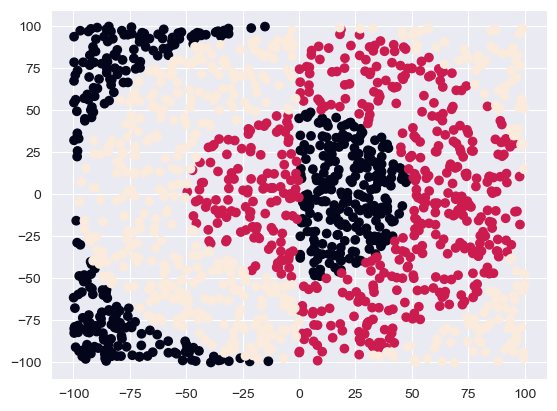

In [5]:
plt.scatter(r3r_train['x'], r3r_train['y'], c=r3r_train['c'])

In [6]:
X = r3r_train[['x', 'y']].to_numpy().transpose()
y = r3r_train['c'].values.reshape(-1, 1)
X_test = r3r_test[['x', 'y']].to_numpy().transpose()
y_test = r3r_test['c'].values.reshape(-1, 1)

In [7]:
encoder = OneHotEncoder(sparse_output=False)
y_oh = encoder.fit_transform(y).transpose()
y_oh_test = encoder.fit_transform(y_test).transpose()

In [8]:
layers = [50, 50, 3]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [softmax]

params = {"eta": 0.005, "momentum": 0.9, "beta": 0.999, "epsilon": 10**(-8)}
N1 = Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N1.train(X=X, Y=y_oh, X_test=X_test, Y_test=y_oh_test, epochs=10000, params=params, batch_size=128)
print(max(N1.f_score_list))

Epoch 1/10000, f-score = 0.21666440496277575, f-score test= 0.24489606877068146
Epoch 101/10000, f-score = 0.4350170029123947, f-score test= 0.49004657051962514
Epoch 201/10000, f-score = 0.4496486880746399, f-score test= 0.4997553626165465
Epoch 301/10000, f-score = 0.4804641549259572, f-score test= 0.534851798463912
Epoch 401/10000, f-score = 0.47955849944061374, f-score test= 0.5342738685123786
Epoch 501/10000, f-score = 0.5252010224637312, f-score test= 0.5517790856984508
Epoch 601/10000, f-score = 0.5248890791257216, f-score test= 0.5473842349469517
Epoch 701/10000, f-score = 0.5228290714835251, f-score test= 0.5443535991229784
Epoch 801/10000, f-score = 0.5240122303990564, f-score test= 0.5404836396498557
Epoch 901/10000, f-score = 0.5243107651706511, f-score test= 0.5372581950610257
Epoch 1001/10000, f-score = 0.5258092298104075, f-score test= 0.53688326991865
Epoch 1101/10000, f-score = 0.5270304296199594, f-score test= 0.537811248245658
Epoch 1201/10000, f-score = 0.5264903178

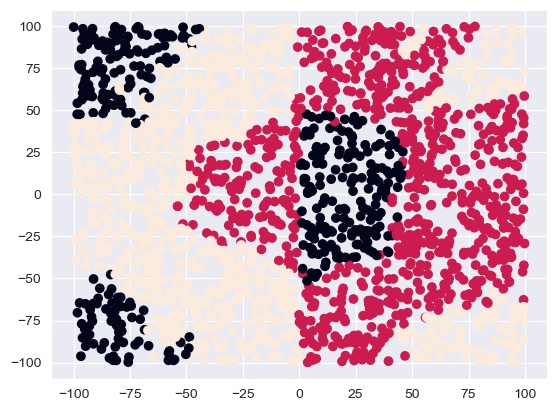

In [9]:
c = np.argmax(N1.forward(X_test).transpose(), axis=1).tolist()
plt.scatter(r3r_test['x'], r3r_test['y'], c=c)

Epoch 1/10000, f-score = 0.27810888878088197, f-score test= 0.24194185171239527
Epoch 101/10000, f-score = 0.45770742319306645, f-score test= 0.486511439637328
Epoch 201/10000, f-score = 0.48568370630642477, f-score test= 0.5162412785915028
Epoch 301/10000, f-score = 0.5026579357333577, f-score test= 0.5129867943546926
Epoch 401/10000, f-score = 0.5239020753367009, f-score test= 0.5318117853853225
Epoch 501/10000, f-score = 0.5427101048418961, f-score test= 0.5520463487346774
Epoch 601/10000, f-score = 0.5577495347972959, f-score test= 0.5541555806811446
Epoch 701/10000, f-score = 0.5654556629902575, f-score test= 0.5616254325923805
Epoch 801/10000, f-score = 0.5712930981050374, f-score test= 0.5648870263308624
Epoch 901/10000, f-score = 0.5786892045713016, f-score test= 0.5689421125149556
Epoch 1001/10000, f-score = 0.5913466592034832, f-score test= 0.5803790142838827
Epoch 1101/10000, f-score = 0.5990835702919927, f-score test= 0.5837052927242606
Epoch 1201/10000, f-score = 0.6195215

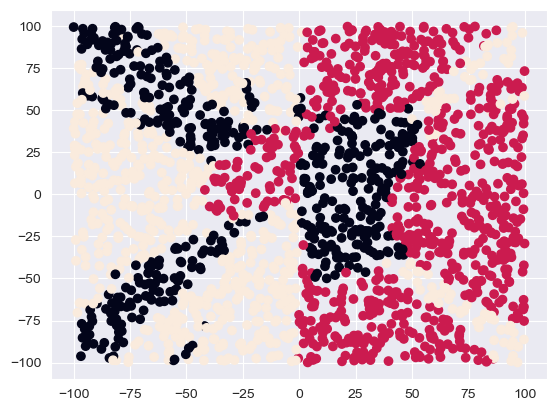

In [11]:
layers = [50, 50, 3]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]

params = {"eta": 0.005, "momentum": 0.9, "beta": 0.999, "epsilon": 10**(-8)}
N1lin = Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N1lin.train(X=X, Y=y_oh, X_test=X_test, Y_test=y_oh_test, epochs=10000, params=params, batch_size=128)
print(max(N1.f_score_list))
clin = np.argmax(N1lin.forward(X_test).transpose(), axis=1).tolist()
plt.scatter(r3r_test['x'], r3r_test['y'], c=clin)

## easy

In [12]:
e_train = pd.read_csv('NN\\classification\\easy-training.csv', dtype=np.longdouble)
e_test = pd.read_csv('NN\\classification\\easy-test.csv', dtype=np.longdouble)

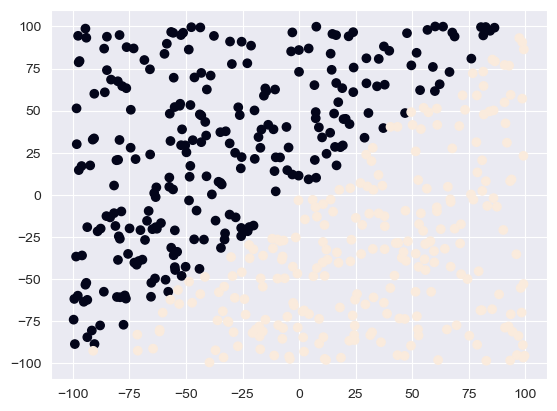

In [13]:
plt.scatter(e_train['x'], e_train['y'], c=e_train['c'])

In [14]:
X = e_train[['x', 'y']].to_numpy().transpose()
y = e_train['c'].values.reshape(-1, 1)
X_test = e_test[['x', 'y']].to_numpy().transpose()
y_test = e_test['c'].values.reshape(-1, 1)

In [15]:
encoder = OneHotEncoder(sparse_output=False)
y_oh = encoder.fit_transform(y).transpose()
y_oh_test = encoder.fit_transform(y_test).transpose()

In [158]:
layers = [30, 30, 2]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [softmax]

params = {"eta": 0.001, "momentum": 0.9, "beta": 0.999, "epsilon": 10**(-8)}
N2 = Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N2.train(X=X, Y=y_oh, X_test=X_test, Y_test=y_oh_test, epochs=3000, params=params, batch_size=128)
print(max(N2.f_score_list))

Epoch 1/3000, f-score = 0.3333333333333333, f-score test= 0.3315508021390374
Epoch 101/3000, f-score = 0.6212394488132169, f-score test= 0.5306050241773794
Epoch 201/3000, f-score = 0.9316841073122117, f-score test= 0.9337772265902496
Epoch 301/3000, f-score = 0.995999935998976, f-score test= 0.995999935998976
Epoch 401/3000, f-score = 0.996, f-score test= 0.995999743983615
Epoch 501/3000, f-score = 0.9939999759999041, f-score test= 0.9919998719979519
Epoch 601/3000, f-score = 0.9939999759999041, f-score test= 0.9919998719979519
Epoch 701/3000, f-score = 0.9939999759999041, f-score test= 0.9919998719979519
Epoch 801/3000, f-score = 0.996, f-score test= 0.9919998719979519
Epoch 901/3000, f-score = 0.996, f-score test= 0.9919998719979519
Epoch 1001/3000, f-score = 0.996, f-score test= 0.9919998719979519
Epoch 1101/3000, f-score = 0.997999991999968, f-score test= 0.9939999759999041
Epoch 1201/3000, f-score = 0.997999991999968, f-score test= 0.9939999759999041
Epoch 1301/3000, f-score = 0.

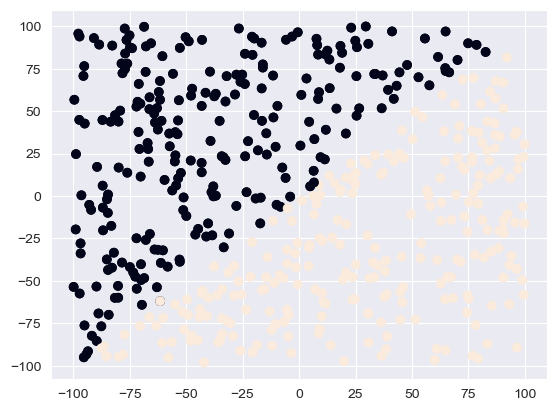

In [160]:
c = np.argmax(N2.forward(X_test).transpose(), axis=1).tolist()
plt.scatter(e_test['x'], e_test['y'], c=c)

Epoch 1/3000, f-score = 0.3333333333333333, f-score test= 0.3351063829787234
Epoch 101/3000, f-score = 0.495345968375014, f-score test= 0.4929270336031042
Epoch 201/3000, f-score = 0.5999935998975985, f-score test= 0.6239939839037425
Epoch 301/3000, f-score = 0.7265826042202779, f-score test= 0.7479584635547938
Epoch 401/3000, f-score = 0.9339405464918427, f-score test= 0.911682055399438
Epoch 501/3000, f-score = 0.9839959029511555, f-score test= 0.9759938544267333
Epoch 601/3000, f-score = 0.98999899989999, f-score test= 0.9839989759344597
Epoch 701/3000, f-score = 0.9879982717511322, f-score test= 0.9879998079969279
Epoch 801/3000, f-score = 0.9799987199180747, f-score test= 0.985999943999776
Epoch 901/3000, f-score = 0.9759996159938559, f-score test= 0.988
Epoch 1001/3000, f-score = 0.9739990639663028, f-score test= 0.985999943999776
Epoch 1101/3000, f-score = 0.9679994879918079, f-score test= 0.9840000000000001
Epoch 1201/3000, f-score = 0.9679994879918079, f-score test= 0.98400000

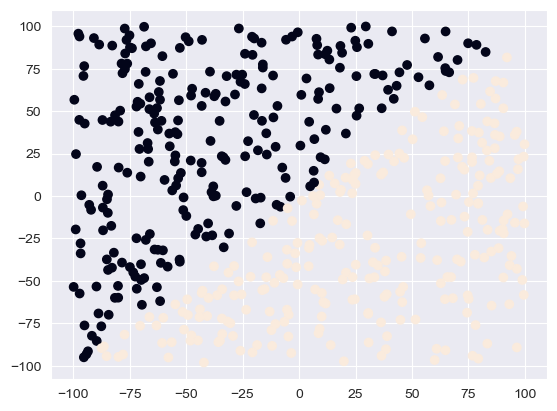

In [17]:
layers = [30, 30, 2]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]

params = {"eta": 0.001, "momentum": 0.9, "beta": 0.999, "epsilon": 10 ** (-8)}
N2lin = Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N2lin.train(X=X, Y=y_oh, X_test=X_test, Y_test=y_oh_test, epochs=3000, params=params, batch_size=128)
print(max(N2lin.f_score_list))
clin = np.argmax(N2lin.forward(X_test).transpose(), axis=1).tolist()
plt.scatter(e_test['x'], e_test['y'], c=clin)

## xor

In [18]:
x_train = pd.read_csv('NN\\classification\\xor3-training.csv', dtype=np.longdouble)
x_test = pd.read_csv('NN\\classification\\xor3-test.csv', dtype=np.longdouble)

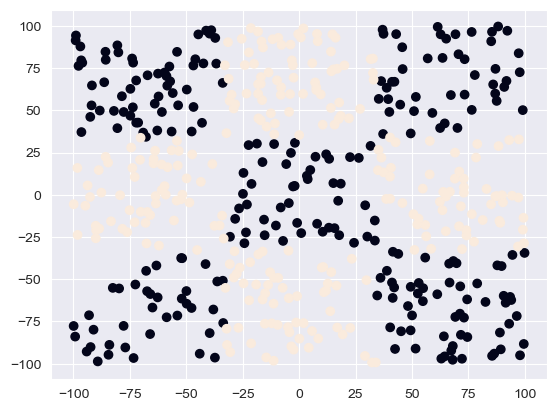

In [171]:
plt.scatter(x_train['x'], x_train['y'], c=x_train['c'])

In [19]:
X = x_train[['x', 'y']].to_numpy().transpose()
y = x_train['c'].values.reshape(-1, 1)
X_test = x_test[['x', 'y']].to_numpy().transpose()
y_test = x_test['c'].values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y_oh = encoder.fit_transform(y).transpose()
y_oh_test = encoder.fit_transform(y_test).transpose()

In [178]:
layers = [30, 50, 30, 2]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [softmax]

params = {"eta": 0.008, "momentum": 0.9, "beta": 0.999, "epsilon": 10**(-8)}
N3 = Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N3.train(X=X, Y=y_oh, X_test=X_test, Y_test=y_oh_test, epochs=70000, params=params, batch_size=128)
print(max(N3.f_score_list))

Epoch 1/70000, f-score = 0.3333333333333333, f-score test= 0.37027707808564225
Epoch 101/70000, f-score = 0.4979979919919679, f-score test= 0.4819575528969905
Epoch 201/70000, f-score = 0.4934143870314084, f-score test= 0.46675574193392605
Epoch 301/70000, f-score = 0.525998103992416, f-score test= 0.48252046762430584
Epoch 401/70000, f-score = 0.508109171655845, f-score test= 0.4543199669284828
Epoch 501/70000, f-score = 0.5338489670653292, f-score test= 0.428341384863124
Epoch 601/70000, f-score = 0.5236265231941842, f-score test= 0.42099845599588265
Epoch 701/70000, f-score = 0.5278111244497798, f-score test= 0.4327234104185777
Epoch 801/70000, f-score = 0.5319325982941544, f-score test= 0.43236714975845414
Epoch 901/70000, f-score = 0.5339086460946345, f-score test= 0.43236714975845414
Epoch 1001/70000, f-score = 0.5318801613212982, f-score test= 0.43236714975845414
Epoch 1101/70000, f-score = 0.5279320222111984, f-score test= 0.43455986220163473
Epoch 1201/70000, f-score = 0.53384

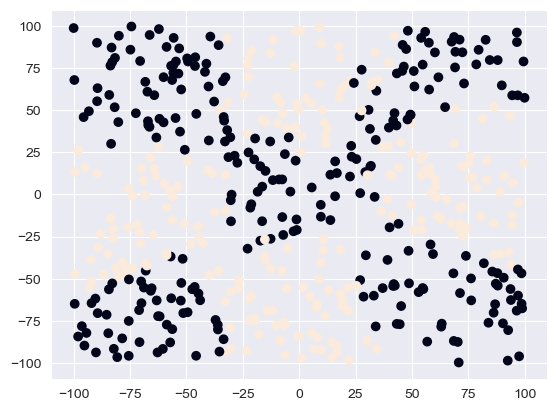

In [180]:
c = np.argmax(N3.forward(X_test).transpose(), axis=1).tolist()
plt.scatter(x_test['x'], x_test['y'], c=c)

Epoch 1/70000, f-score = 0.3333333333333333, f-score test= 0.29178470254957506
Epoch 101/70000, f-score = 0.5256793592468508, f-score test= 0.45452503569652336
Epoch 201/70000, f-score = 0.5238781127968759, f-score test= 0.45617055775629217
Epoch 301/70000, f-score = 0.5567073586578463, f-score test= 0.45913461538461536
Epoch 401/70000, f-score = 0.5492047972623708, f-score test= 0.43797671617824163
Epoch 501/70000, f-score = 0.5681187251668267, f-score test= 0.4486215538847118
Epoch 601/70000, f-score = 0.5683407016571702, f-score test= 0.4486215538847118
Epoch 701/70000, f-score = 0.5551387486173232, f-score test= 0.44199116820553996
Epoch 801/70000, f-score = 0.5532118657311498, f-score test= 0.4441300534999739
Epoch 901/70000, f-score = 0.557062744767929, f-score test= 0.44626348228043144
Epoch 1001/70000, f-score = 0.5609022556390977, f-score test= 0.44839150964211644
Epoch 1101/70000, f-score = 0.5609022556390977, f-score test= 0.4481435549187467
Epoch 1201/70000, f-score = 0.593

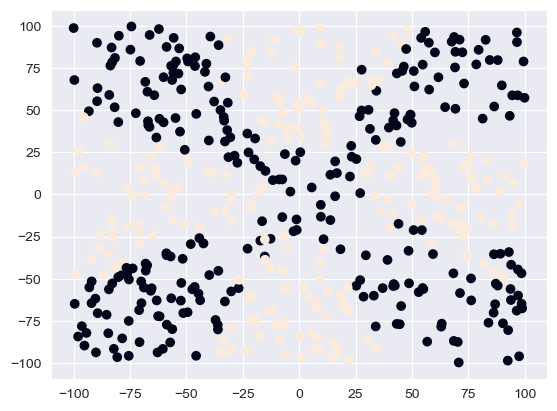

In [20]:
layers = [30, 50, 30, 2]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]

params = {"eta": 0.008, "momentum": 0.9, "beta": 0.999, "epsilon": 10**(-8)}
N3lin = Network(size_layers=layers, size_input=2, activate_fun_array=fun_activation)
N3lin.train(X=X, Y=y_oh, X_test=X_test, Y_test=y_oh_test, epochs=70000, params=params, batch_size=128)
print(max(N3lin.f_score_list))
clin = np.argmax(N3lin.forward(X_test).transpose(), axis=1).tolist()
plt.scatter(x_test['x'], x_test['y'], c=clin)